## Introduction

In this notebook, I implement the training process for a binary classifier that detects signs of pneumonia in chest X-ray images. The dataset used comes from the RSNA Pneumonia Detection Challenge, and the model is built using PyTorch Lightning for efficient experimentation.

## Imports
 
 - `torch` and `torchvision` for model definition and data loading
 - `torchvision.transforms` for preprocessing and data augmentation
 - `torchmetrics` to calculate performance metrics
 - `pytorch_lightning` for training and experiment management
 - `ModelCheckpoint` and `TensorBoardLogger` to save models and track metrics

In [1]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

We first create the dataset. `torchvision.datasets.DatasetFolder` simplifies this by automatically associating directory names with class labels. All we need to provide is a loader function for our `.npy` images.

In [2]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [3]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))])

In [4]:
val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])

We now instantiate both the training and validation datasets and their corresponding data loaders. Adjust `batch_size` and `num_workers` depending on your system's capabilities.

In [5]:
import os
print(os.getcwd())

E:\ESTUDIOS\CursoUdemyAIMedicalImages\AI-IN-MEDICAL-MATERIALS\04-Pneumonia-Classification\notebooks


In [6]:
train_dataset = torchvision.datasets.DatasetFolder(
    "../data/Processed/train/",
    loader=load_file, extensions="npy", transform=train_transforms)

In [7]:
val_dataset = torchvision.datasets.DatasetFolder(
    "../data/Processed/val/",
    loader=load_file, extensions="npy", transform=val_transforms)

Let's take a look at some augmented training samples to verify the transforms.

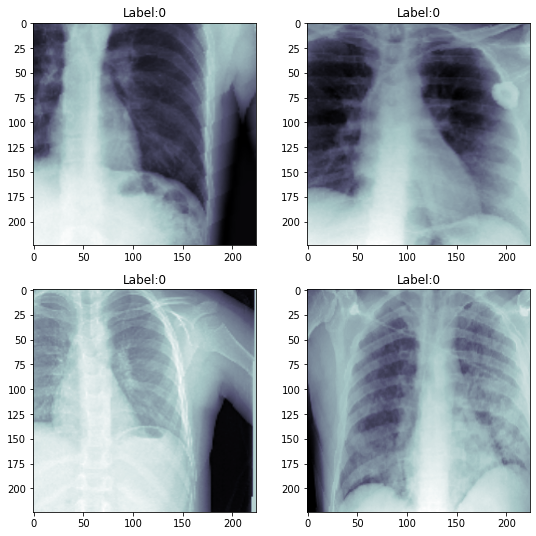

In [8]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

When training deep learning models with PyTorch, it's common to use multiple `num_workers` in the `DataLoader` to speed up data loading using parallel processes.

However, Jupyter Notebooks have limitations with multiprocessing on Windows, which can lead to unexpected behavior or crashes when `num_workers > 0`.

To address this, we check whether the code is being run in a notebook or as a standalone Python script. If it's in a notebook, we use `num_workers = 0`; otherwise, we use a higher value (e.g., 8) to enable multiprocessing.

In [9]:
import os

In [10]:
import os
import sys

In [11]:
def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        return shell == "ZMQInteractiveShell"
    except NameError:
        return False

In [12]:
# Use more workers if safe (e.g. script, not notebook)
if os.name == 'nt' and not is_notebook():
    num_workers = min(8, os.cpu_count())  # Use up to 8 workers safely
    persistent_workers = True
else:
    num_workers = 0
    persistent_workers = False

In [13]:
batch_size = 64  # Puedes ajustar según tu GPU o RAM

In [14]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=True,
    persistent_workers=persistent_workers
)

In [15]:
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=True,
    persistent_workers=persistent_workers
)

In [16]:
print(f"Using num_workers = {num_workers}")
print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

Using num_workers = 0
There are 24000 train images and 2684 val images


This dataset is imbalanced—there are more healthy samples than pneumonia cases. Some ways to address this include:
- Using a weighted loss function
- Oversampling the minority class
- Proceeding without adjustment
 
For simplicity, I continue without rebalancing. This often provides competitive results, but other strategies can be explored.

In [17]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([18593,  5407], dtype=int64)),
 (array([0, 1]), array([2079,  605], dtype=int64)))

## Model Definition with PyTorch Lightning

A PyTorch Lightning model requires:
- An `__init__` method to define layers
- A `forward()` method for predictions
- A `training_step()` to compute loss
- `configure_optimizers()` to define the optimizer
 
Optionally, we can also implement validation/test logic.

Now I define the model architecture. I use ResNet18 from `torchvision.models`, modifying the first convolutional layer to accept a single-channel input since X-ray images are grayscale.

### Optimizer and Loss Function

I use the Adam optimizer with a learning rate of 0.0001, and `BCEWithLogitsLoss` as the loss function. This loss function internally applies the sigmoid activation, making it ideal for binary classification.

In [18]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight], device="cuda"))

        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()

        # Métricas por epoch para guardar
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def forward(self, data):
        return self.model(data)
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        acc = self.train_acc(torch.sigmoid(pred), label.int())

        self.log("train_loss", loss)
        self.log("step_train_acc", acc)
        return {"loss": loss, "acc": acc}
    
    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['acc'] for x in outputs]).mean()

        self.log("train_acc", avg_acc, prog_bar=True)
        self.log("train_loss", avg_loss, prog_bar=True)

        self.train_losses.append(avg_loss.item())
        self.train_accuracies.append(avg_acc.item())

    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        acc = self.val_acc(torch.sigmoid(pred), label.int())

        self.log("val_loss", loss)
        self.log("step_val_acc", acc)
        return {"val_loss": loss, "val_acc": acc}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()

        self.log("val_acc", avg_acc, prog_bar=True)
        self.log("val_loss", avg_loss, prog_bar=True)

        self.val_losses.append(avg_loss.item())
        self.val_accuracies.append(avg_acc.item())

    def configure_optimizers(self):
        return [self.optimizer]

    def save_metrics(self, filename="metrics.csv"):
        import pandas as pd
        length = min(len(self.train_losses), len(self.train_accuracies),
                 len(self.val_losses), len(self.val_accuracies))

        df = pd.DataFrame({
            "epoch": list(range(length)),
            "train_loss": self.train_losses[:length],
            "train_acc": self.train_accuracies[:length],
            "val_loss": self.val_losses[:length],
            "val_acc": self.val_accuracies[:length]
        })
        df.to_csv(filename, index=False)

In [19]:
model = PneumoniaModel().to("cuda")  # Instanciate the model

Here, I define a checkpoint callback to save the top 10 models during training based on validation accuracy.

In [20]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',  # <--- corregido
    save_top_k=10,
    mode='max',
    dirpath='weights/ckpts_original',
    filename='-{epoch:02d}-{val_acc:.2f}'
)

You can refer to the PyTorch Lightning Trainer documentation for more configuration options: https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html

Create the trainer
Change the gpus parameter to the number of available gpus on your system. Use 0 for CPU training

In [21]:
trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        logger=TensorBoardLogger(save_dir="../logs/original"),
        log_every_n_steps=1,
        callbacks=[checkpoint_callback],
        max_epochs=35
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


## Training Setup (Executed via Python Script)

To ensure full compatibility with multiprocessing (`num_workers > 0`) on Windows, we performed the actual model training using a standalone Python script (`train_original.py`) instead of running the training directly inside this notebook.

This approach allows us to:
- Use `num_workers = 8` for faster data loading during training.
- Avoid runtime errors associated with multiprocessing in Jupyter on Windows.
- Keep the notebook clean and focused on analysis.

### Model Saving Strategy

During training, we saved the model in multiple formats to enable flexible evaluation:

- **Checkpoints (`.ckpt`)** using PyTorch Lightning's `ModelCheckpoint` callback, which saves the model's state at different epochs based on validation accuracy.
- **Final model weights (`.pth`)** using PyTorch's `torch.save(...)`, allowing us to reload the full trained architecture later for direct evaluation or deployment.
- **Training metrics per epoch** (`metrics.csv`), including loss and accuracy for both training and validation, which are used to plot learning curves and compare training strategies.

This setup ensures we can extract a wide range of metrics and comparisons, including confusion matrices, precision, recall, and more, both during and after training.


In [23]:
trainer.fit(model, train_loader, val_loader)
model.save_metrics("../metrics/metrics.csv")
torch.save(model.model.state_dict(), "../weights/resnet18_pneumonia.pth")

## 🔧 Model Evaluation

In this section, we will load the pre-trained model saved during the training phase to evaluate its performance on the validation set.

We will use the checkpoint file (`.cpk`) that was saved during training, which contains the model's learned weights. This allows us to **reuse the trained model** without needing to retrain it from scratch.

### Steps:
1. **Load the saved model** from the checkpoint.
2. **Evaluate the model** on the validation set.
3. Visualize the **performance metrics**, such as accuracy, precision, recall, and the confusion matrix.
4. Optionally, generate **Class Activation Maps (CAM)** to understand which regions of the images the model is focusing on during its predictions.

This evaluation will help us understand how well the model generalizes to unseen data and whether the learned features are useful for making accurate predictions.

In [22]:
model = PneumoniaModel.load_from_checkpoint("../weights/ckpts_original/-epoch=17-val_acc=0.85.ckpt")
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def evaluate_model_sklearn(model, loader, threshold=0.5):
    model.eval()
    preds = []
    labels = []
    device = "cuda" if torch.cuda.is_available() else "cpu"

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            output = torch.sigmoid(model(x)).squeeze().cpu()
            preds.append(output)
            labels.append(y)

    preds = torch.cat(preds)
    labels = torch.cat(labels).int()
    preds_class = (preds > threshold).int()

    acc = accuracy_score(labels, preds_class)
    precision = precision_score(labels, preds_class)
    recall = recall_score(labels, preds_class)
    cm = confusion_matrix(labels, preds_class)

    return acc, precision, recall, cm

In [24]:
acc_b, prec_b, rec_b, cm_b = evaluate_model_sklearn(model, val_loader)
print("Evaluation Metrics - Model")
print("=" * 40)
print(f"{'Accuracy':<12}: {acc_b:.4f}")
print(f"{'Precision':<12}: {prec_b:.4f}")
print(f"{'Recall':<12}: {rec_b:.4f}")
print()

print("Confusion Matrix (Model)")
print("=" * 40)
print(f"{'':<12} Predicted: 0   Predicted: 1")
print(f"Actual: 0   {cm_b[0][0]:<13} {cm_b[0][1]}")
print(f"Actual: 1   {cm_b[1][0]:<13} {cm_b[1][1]}")

Evaluation Metrics - Model
Accuracy    : 0.8517
Precision   : 0.7424
Recall      : 0.5240

Confusion Matrix (Model)
             Predicted: 0   Predicted: 1
Actual: 0   1969          110
Actual: 1   288           317


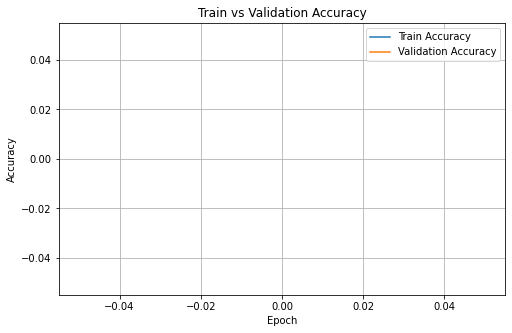

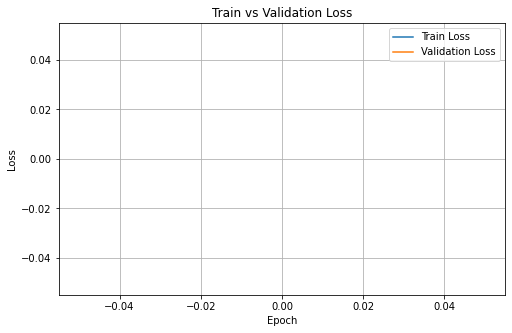

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar métricas guardadas
df = pd.read_csv("../metrics/metrics.csv")

plt.figure(figsize=(8,5))
plt.plot(df["epoch"].to_numpy(), df["train_acc"].to_numpy(), label="Train Accuracy")
plt.plot(df["epoch"].to_numpy(), df["val_acc"].to_numpy(), label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8,5))
plt.plot(df["epoch"].to_numpy(), df["train_loss"].to_numpy(), label="Train Loss")
plt.plot(df["epoch"].to_numpy(), df["val_loss"].to_numpy(), label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## Note on Balanced Training Comparison

This notebook demonstrates the training of a binary classification model without any class balancing strategy. The dataset is slightly imbalanced, with a higher number of normal (healthy) chest X-rays than pneumonia cases.

To evaluate the impact of class imbalance on model performance, we have also trained a version of this model using a **balanced approach** via weighted sampling. You can find this in the separate notebook: **`train_balanced.ipynb`**.

In that notebook, we compare the performance of both models using:
- Accuracy
- Precision
- Recall
- Confusion matrices

### Why this matters:
In medical diagnosis tasks, **recall is critical** — failing to detect a disease can have serious consequences. The balanced model prioritizes sensitivity (recall), even at the cost of a few more false positives. The comparison shows that **class balancing can significantly improve the model’s ability to detect pneumonia**.

You are encouraged to view `train_balanced.ipynb` to understand how class weighting affects model behavior and to select the training strategy best suited for your application.
